### Import Packages

In [203]:
import statsmodels.api as sm
from statsmodels.formula.api import glm
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
#from lightgbm import LGBMClassifier
import category_encoders as ce
import warnings
warnings.filterwarnings("ignore")

### Import Dataset

In [96]:
train = pd.read_csv('Project2_Train.csv')
test = pd.read_csv('Project2_Test.csv')

## 1. Logistic Regression

#### Preprocessing Data


In [171]:
train_lg = pd.get_dummies(train, columns = ['Region_Code'])
train_lg = train_lg.drop(["id", "Region_Code_50"], axis = 1)
train_lg['Gender']=train_lg['Gender'].replace({'Male':1,'Female':0})
train_lg['Vehicle_Damage'].replace({'Yes':1,'No':0}, inplace=True)
train_lg['Vehicle_Age'].replace({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3}, inplace=True)
train_lg['Age']=np.log(train_lg['Age'])
train_lg['Annual_Premium']=np.log(train_lg['Annual_Premium'])
train_lg['Vintage']=np.log(train_lg['Vintage'])

In [172]:
X_lg = train_lg.loc[:, train_lg.columns != 'Response']
y_lg = np.ravel(train_lg.loc[:, train_lg.columns == 'Response'])
X_train_lg, X_val_lg, y_train_lg, y_val_lg = train_test_split(X_lg, y_lg, random_state = 42)

#### Fitting the Model

In [173]:
logreg = LogisticRegressionCV(cv=5, scoring='accuracy')
logreg.fit(X_train_lg, y_train_lg)
y_pred_problg = logreg.predict_proba(X_val_lg)[:, 1]
probabilitythresholdlg = 0.25
y_pred_thresholdlg = (y_pred_problg >= probabilitythresholdlg).astype(int)
print('Accuracy: ',metrics.accuracy_score(y_val_lg, y_pred_thresholdlg))
print(classification_report(y_val_lg, y_pred_thresholdlg))

Accuracy:  0.8624
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      2156
           1       0.00      0.00      0.00       344

    accuracy                           0.86      2500
   macro avg       0.43      0.50      0.46      2500
weighted avg       0.74      0.86      0.80      2500



#### Test for Overfitting

In [174]:
print('Score:', logreg.score(X_train_lg, y_train_lg))
print('Score:', logreg.score(X_val_lg, y_val_lg))

Score: 0.8690666666666667
Score: 0.8624


#### AUC ###

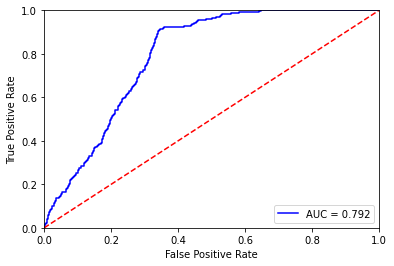

In [175]:
fpr, tpr, threshold = metrics.roc_curve(y_val_lg, y_pred_problg)
roc_auc = metrics.auc(fpr, tpr)
auc_lr = metrics.roc_auc_score(y_val_lg, y_pred_problg)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Model Summary 

In [176]:
logit_model = sm.Logit(y_lg, X_lg)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.302282
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9985
Method:                           MLE   Df Model:                           14
Date:                Fri, 02 Dec 2022   Pseudo R-squ.:                  0.2275
Time:                        00:58:22   Log-Likelihood:                -3022.8
converged:                       True   LL-Null:                       -3913.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Gender             0.0912      0.066      1.387      0.165      -0.038       0.220
Age              

## 2. Classification Tree: Gini

#### Preprocessing Data

In [122]:
train_clf = pd.get_dummies(train, columns = ['Region_Code'])
train_clf = train_clf.drop(["id", "Region_Code_50"], axis = 1)
train_clf['Gender']=train_clf['Gender'].replace({'Male':1,'Female':0})
train_clf['Vehicle_Damage'].replace({'Yes':1,'No':0}, inplace=True)
train_clf['Vehicle_Age'].replace({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3}, inplace=True)
train_clf['Age']=np.log(train_clf['Age'])
train_clf['Annual_Premium']=np.log(train_clf['Annual_Premium'])
train_clf['Vintage']=np.log(train_clf['Vintage'])

In [127]:
X_clf = train_clf.loc[:, train_clf.columns != 'Response']
y_clf = np.ravel(train_clf.loc[:, train_clf.columns == 'Response'])
X_train_clf, X_val_clf, y_train_clf, y_val_clf = train_test_split(X_clf, y_clf, random_state = 42)

#### Hyperparameter Tuning 

In [140]:
DecisionTreeGini = DecisionTreeClassifier(criterion = "gini", random_state=0) 

# Setup the parameters and distributions to sample from:
param_dist = {"max_depth": np.arange(1,10),
              'min_samples_leaf': [2,4,6,8,10,12,14],
              'max_features': np.arange(1,10)}
                                
# Instantiate the GridSearchCV object:
clf_gridsearch = GridSearchCV(DecisionTreeGini, param_dist, scoring='roc_auc', cv=10)
clf_gridsearch.fit(X_train_clf, y_train_clf) 

best_hyperparams = clf_gridsearch.best_params_
print('Best hyerparameters:\n', best_hyperparams)

Best hyerparameters:
 {'max_depth': 4, 'max_features': 8, 'min_samples_leaf': 12}


#### Fitting the Model

Accuracy:  0.7372
              precision    recall  f1-score   support

           0       0.95      0.73      0.83      2156
           1       0.32      0.78      0.45       344

    accuracy                           0.74      2500
   macro avg       0.63      0.75      0.64      2500
weighted avg       0.87      0.74      0.78      2500



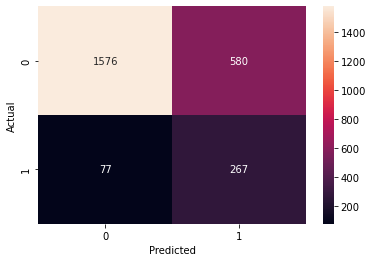

In [148]:
DecisionTreeCLF = DecisionTreeClassifier(criterion = "gini", random_state=0, max_depth = 4, max_features = 8, min_samples_leaf = 12)
DecisionTreeCLF.fit(X_train_clf,y_train_clf)
y_pred_probclf = DecisionTreeCLF.predict_proba(X_val_clf)[:, 1]
probabilitythreshold_clf=0.25
y_pred_thresholdclf = (y_pred_probclf>=probabilitythreshold_clf).astype(int)

confusion_matrix_clf = pd.crosstab(y_val_clf, y_pred_thresholdclf, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix_clf, annot=True, fmt='')

print('Accuracy: ',metrics.accuracy_score(y_val_clf, y_pred_thresholdclf))
print(classification_report(y_val_clf, y_pred_thresholdclf))

#### AUC

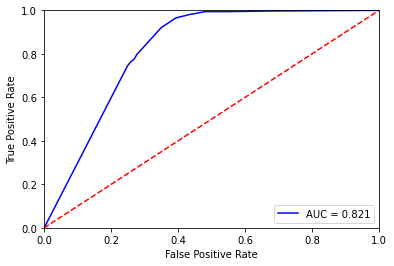

In [161]:
fpr, tpr, threshold = metrics.roc_curve(y_val_clf, y_pred_probclf)
roc_auc = metrics.auc(fpr, tpr)
auc_clf = metrics.roc_auc_score(y_val_clf, y_pred_probclf)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Plot Classification tree diagram

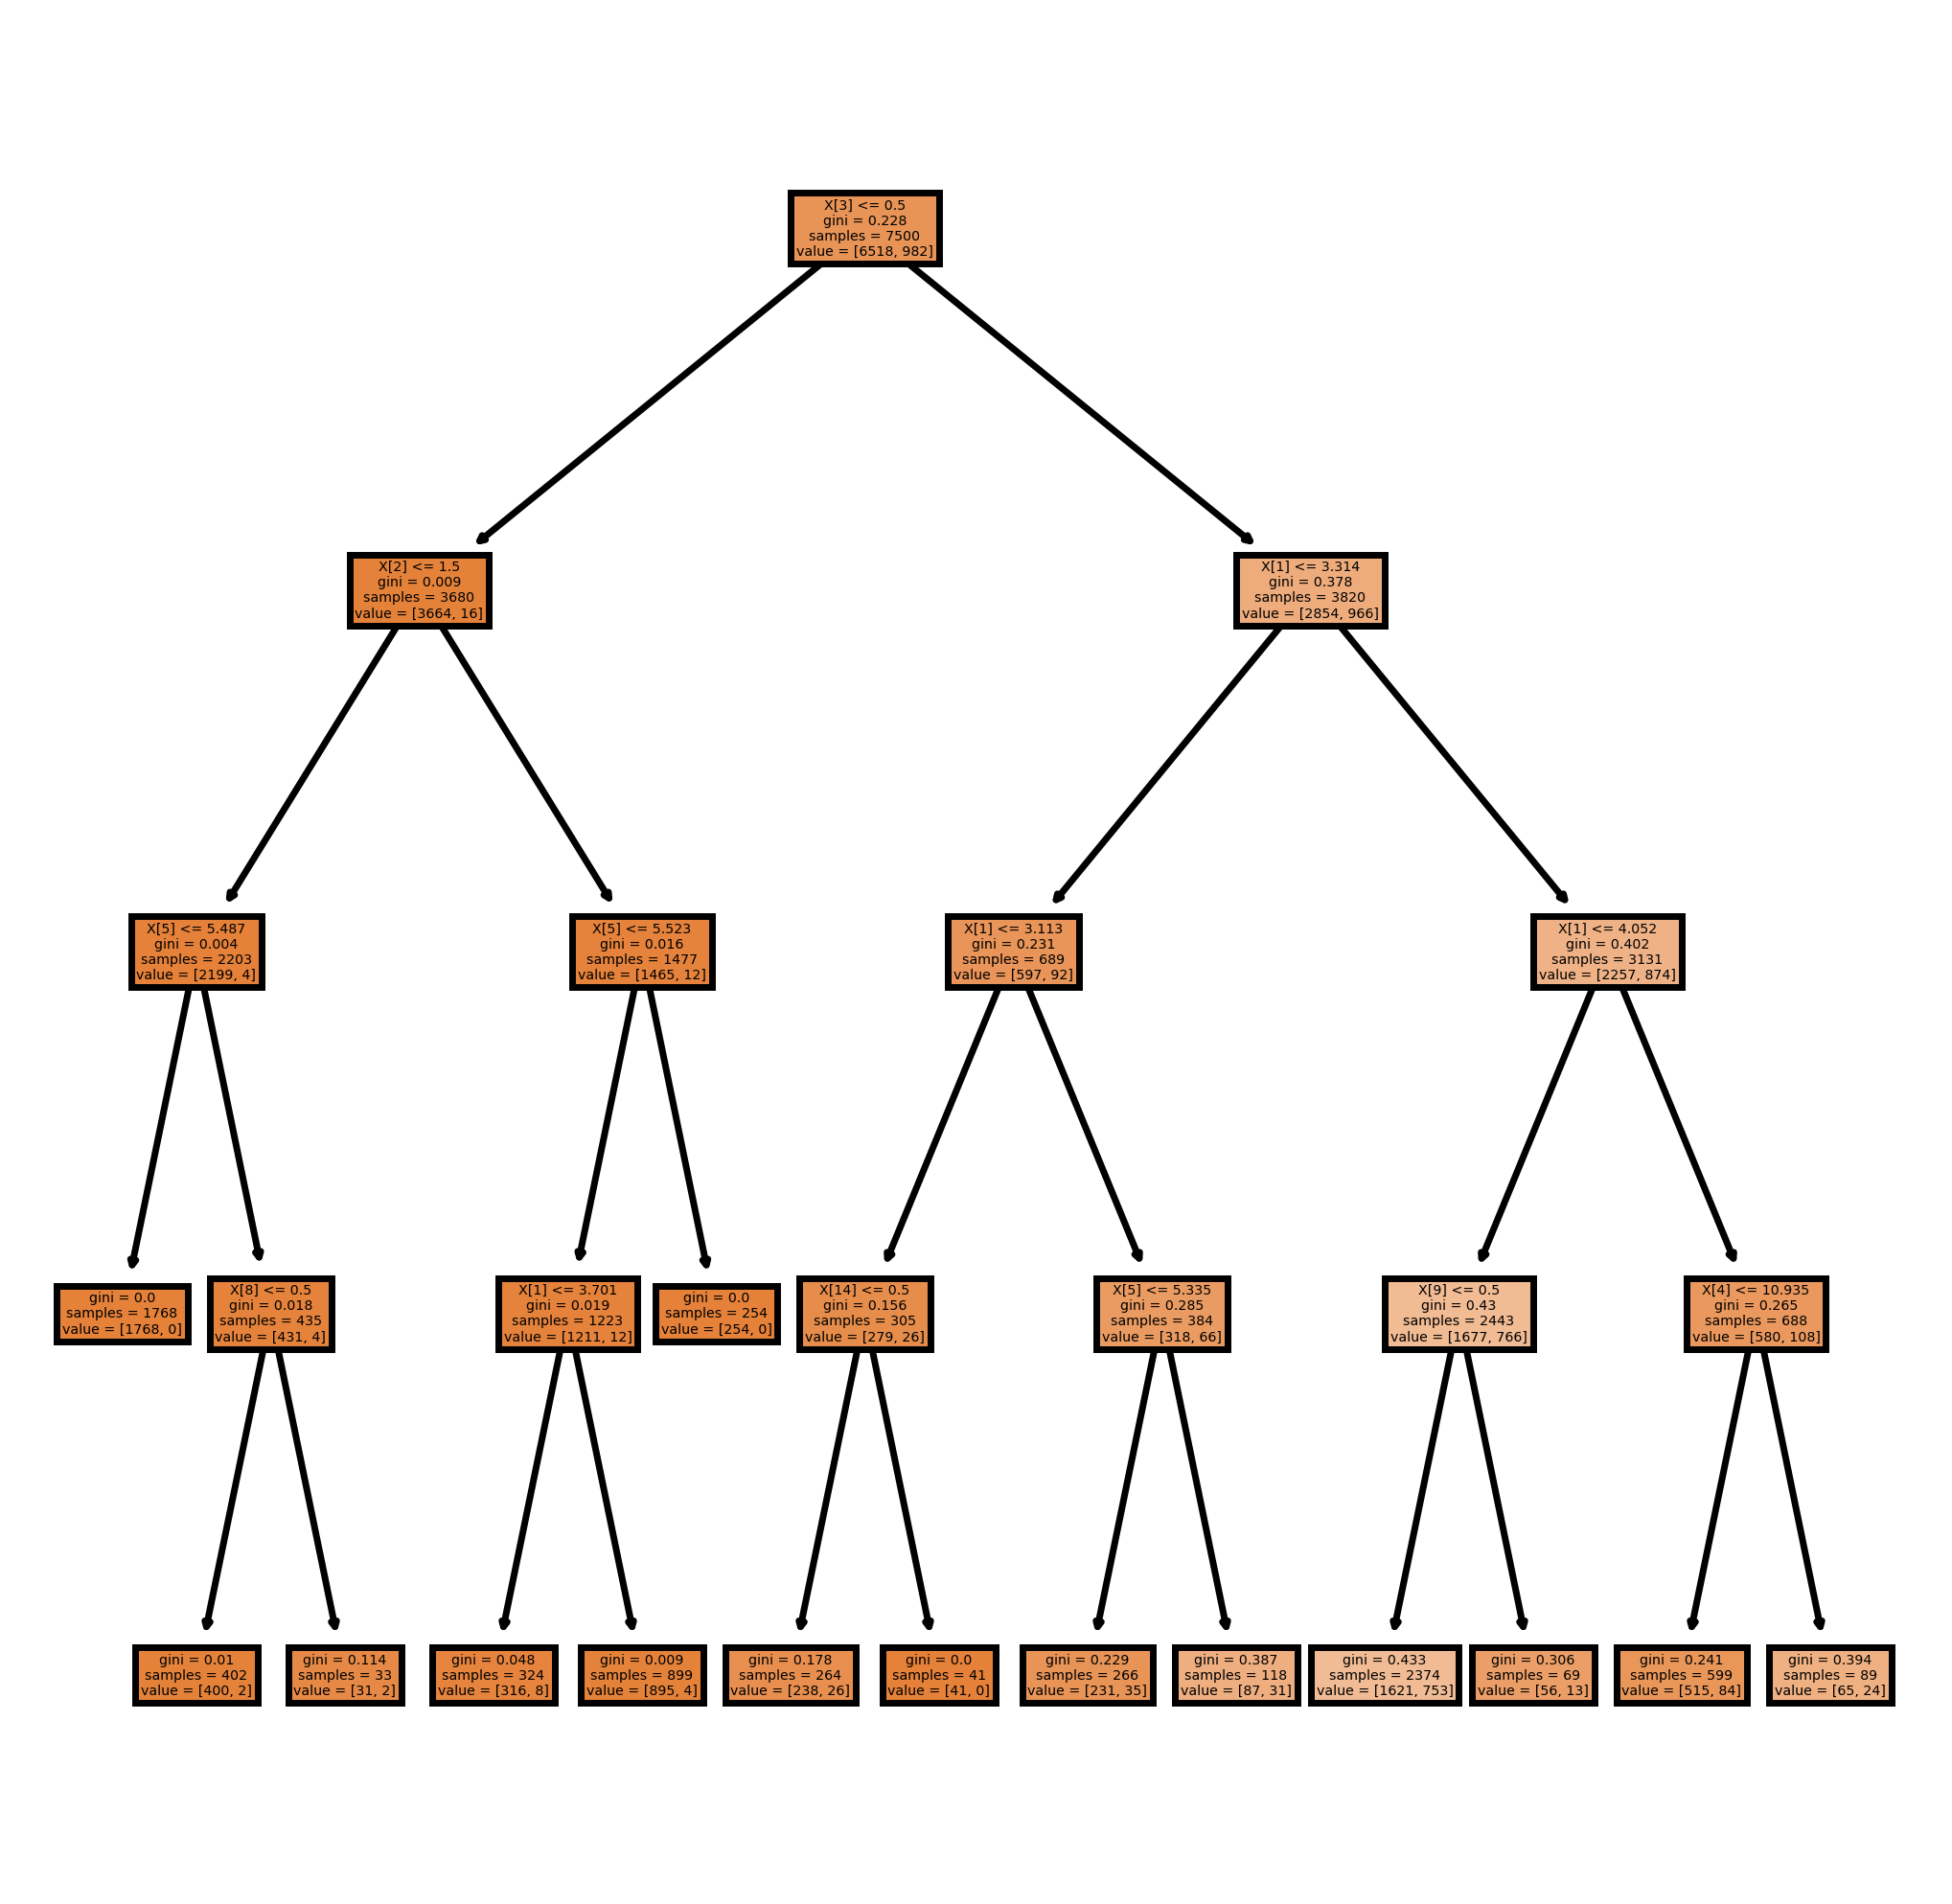

In [162]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=500)
tree.plot_tree(DecisionTreeCLF,
               filled = True);
fig.savefig('imagename.png')

## 3. Random Forest: Gini 

#### Preprocessing Data

In [151]:
train_rf = pd.get_dummies(train, columns = ['Region_Code'])
train_rf = train_rf.drop(["id", "Region_Code_50"], axis = 1)
train_rf['Gender']=train_rf['Gender'].replace({'Male':1,'Female':0})
train_rf['Vehicle_Damage'].replace({'Yes':1,'No':0}, inplace=True)
train_rf['Vehicle_Age'].replace({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3}, inplace=True)
train_rf['Age']=np.log(train_rf['Age'])
train_rf['Annual_Premium']=np.log(train_rf['Annual_Premium'])
train_rf['Vintage']=np.log(train_rf['Vintage'])

In [152]:
X_rf = train_rf.loc[:, train_rf.columns != 'Response']
y_rf = np.ravel(train_rf.loc[:, train_rf.columns == 'Response'])
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(X_rf, y_rf, random_state = 0)

#### Hyperparameter Tuning


In [153]:
RandomForest = RandomForestClassifier(criterion='gini', random_state=42)

# Setup the parameters and distributions to sample from:
param_dist = {'max_depth': np.arange(3,10),
              'min_samples_leaf': [1,2,4,6,8],
              'max_features': [1,2,4,6,8],
              'n_estimators': [100,200,300]
             }

# Instantiate the GridSearchCV object: 
RF_cv = GridSearchCV(RandomForest, param_dist,scoring='roc_auc', cv=5)
RF_cv.fit(X_train_rf,y_train_rf)


best_hyperparams = RF_cv.best_params_
print('Best hyerparameters:\n', best_hyperparams)


Best hyerparameters:
 {'max_depth': 5, 'max_features': 8, 'min_samples_leaf': 8, 'n_estimators': 300}


#### Fitting the Model

Accuracy:  0.7372
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      2150
           1       0.32      0.79      0.46       350

    accuracy                           0.74      2500
   macro avg       0.64      0.76      0.64      2500
weighted avg       0.87      0.74      0.77      2500



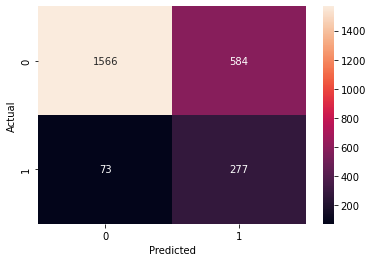

In [157]:
RandomForestCLF = RandomForestClassifier(criterion='gini', n_estimators = 300, max_features=8, max_depth = 5, random_state = 42, min_samples_leaf= 8)
RandomForestCLF.fit(X_train_rf,y_train_rf)
y_pred_probrf = RandomForestCLF.predict_proba(X_val_rf)[:, 1]
probabilitythreshold_rf = 0.25
y_pred_thresholdrf = (y_pred_probrf>=probabilitythreshold_rf).astype(int)

confusion_matrix_rf = pd.crosstab(y_val_rf, y_pred_thresholdrf, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix_rf, annot=True, fmt='g')

print('Accuracy: ',metrics.accuracy_score(y_val_rf, y_pred_thresholdrf))
print(classification_report(y_val_rf, y_pred_thresholdrf))

#### Feature importance

In [158]:
feature_imp_rf = pd.Series(RandomForestCLF.feature_importances_,index=X_rf.columns.values).sort_values(ascending=False)
feature_imp_rf

Vehicle_Damage    0.627720
Age               0.206880
Vehicle_Age       0.065624
Vintage           0.027496
Annual_Premium    0.025532
Region_Code_28    0.017606
Region_Code_29    0.006860
Region_Code_46    0.004987
Gender            0.004371
Region_Code_41    0.003248
Region_Code_11    0.003152
Region_Code_15    0.002704
Region_Code_8     0.002420
Region_Code_3     0.001001
Region_Code_30    0.000398
dtype: float64

#### AUC

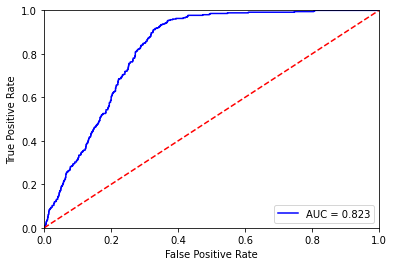

In [163]:
fpr, tpr, threshold = metrics.roc_curve(y_val_rf, y_pred_probrf)
roc_auc = metrics.auc(fpr, tpr)
auc_rf = metrics.roc_auc_score(y_val_rf, y_pred_probrf)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 4. LightGBM

#### Preprocessing Data

In [204]:
train_gbm = pd.get_dummies(train, columns = ['Region_Code'])
train_gbm = train_gbm.drop(["id", "Region_Code_50"], axis = 1)
train_gbm['Gender']=train_rf['Gender'].replace({'Male':1,'Female':0})
train_gbm['Vehicle_Damage'].replace({'Yes':1,'No':0}, inplace=True)
train_gbm['Vehicle_Age'].replace({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3}, inplace=True)
train_gbm['Age']=np.log(train_rf['Age'])
train_gbm['Annual_Premium']=np.log(train_gbm['Annual_Premium'])
train_gbm['Vintage']=np.log(train_gbm['Vintage'])

In [205]:
y = train_gbm.Response
X = train_gbm.drop('Response', axis =1)

X_train_gbm, X_val_gbm, y_train_gbm, y_val_gbm = train_test_split(X, y, test_size = 0.3, random_state = 0)

#### Hyperparameter Tuning

In [225]:
lgbm_clf = LGBMClassifier()

# Setup the parameters and distributions to sample from:
param_dist = {'max_depth':[2,3,4,5],
              'n_estimators': [250, 300, 350],
              'num_leaves' : [4,5,6,7],
              'learning_rate' : [0.1,0.01, 0.001]
             }

# Instantiate the GridSearchCV object: 
lgbm_cv = GridSearchCV(lgbm_clf, param_dist,scoring='roc_auc', cv=5)
lgbm_cv.fit(X_train_gbm,y_train_gbm)


best_hyperparams = lgbm_cv.best_params_
print('Best hyerparameters:\n', best_hyperparams)

Best hyerparameters:
 {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 350, 'num_leaves': 4}


#### Fitting the Model

Accuracy: 0.743
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      2582
           1       0.33      0.81      0.47       418

    accuracy                           0.74      3000
   macro avg       0.64      0.77      0.65      3000
weighted avg       0.87      0.74      0.78      3000



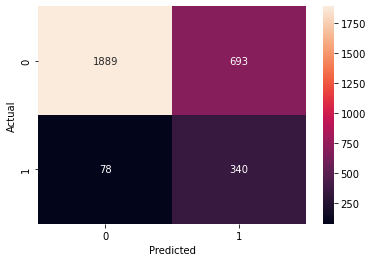

In [231]:
lgbm_clf = LGBMClassifier( max_depth = 3, n_estimators = 350, num_leaves = 4, learning_rate = 0.01)
lgbm_clf.fit(X_train_gbm, y_train_gbm)
lgbm_clf_pred_proba = lgbm_clf.predict_proba(X_val_gbm)[:,1]
probabilitythreshold_clf = 0.25
y_pred_threshold_clf = (lgbm_clf_pred_proba>=probabilitythreshold_clf).astype(int)
confusion_matrix = pd.crosstab(y_val_gbm, y_pred_threshold_clf, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt = '')

print('Accuracy:',metrics.accuracy_score(y_val_gbm,y_pred_threshold_clf))
print(classification_report(y_val_gbm,y_pred_threshold_clf))

#### AUC 

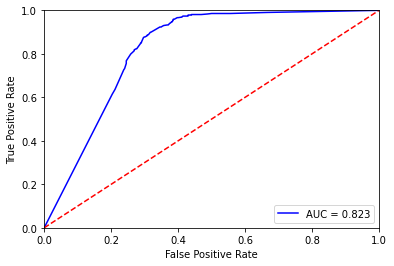

In [232]:
fpr, tpr, _ = metrics.roc_curve(y_val_gbm,  lgbm_clf_pred_proba)
auc_gbm = metrics.roc_auc_score(y_val_gbm, lgbm_clf_pred_proba)


plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % auc_gbm)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<AxesSubplot:>

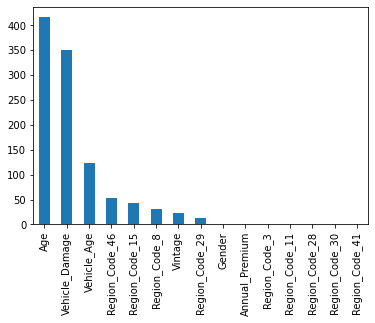

In [233]:
feature_imp_lgbm = pd.Series(lgbm_clf.feature_importances_,index=X.columns.values).sort_values(ascending=False)
feature_imp_lgbm

feature_imp_lgbm.plot.bar()


### AUC Summary 

In [234]:
print('AUC of Logistic Regression is:', auc_lr)
print('AUC of Classification Tree is:', auc_clf)
print('AUC of Random Forest is:', auc_rf)
print('AUC of LightGBM is:', auc_gbm)

AUC of Logistic Regression is: 0.7923965569314406
AUC of Classification Tree is: 0.8214872233248479
AUC of Random Forest is: 0.8234053156146178
AUC of LightGBM is: 0.8225824534224795


## Final model selection
###### According to AUC, Random Forest has the best performance. Therefore, the chosen model will be Random Forest. 


#### Test Set

In [235]:
test_rf = pd.get_dummies(test, columns = ['Region_Code'])
test_rf = test_rf.drop(["id", "Region_Code_50"], axis = 1)
test_rf['Gender']=test_rf['Gender'].replace({'Male':1,'Female':0})
test_rf['Vehicle_Damage'].replace({'Yes':1,'No':0}, inplace=True)
test_rf['Vehicle_Age'].replace({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3}, inplace=True)
test_rf['Age']=np.log(test_rf['Age'])
test_rf['Annual_Premium']=np.log(test_rf['Annual_Premium'])
test_rf['Vintage']=np.log(test_rf['Vintage'])

X_test_rf = test_rf.loc[:, test_rf.columns != 'Response']
y_test_rf = np.ravel(test_rf.loc[:, test_rf.columns == 'Response'])

### Fitting test set to Random Forest Model 

Accuracy:  0.7358
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      8636
           1       0.31      0.79      0.45      1364

    accuracy                           0.74     10000
   macro avg       0.64      0.76      0.64     10000
weighted avg       0.87      0.74      0.77     10000



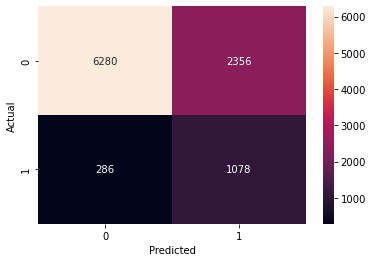

In [238]:
y_pred_prob_rf = RandomForestCLF.predict_proba(X_test_rf)[:, 1]
probability_threshold_rf = 0.25
y_pred_threshold_rf = (y_pred_prob_rf >= probability_threshold_rf).astype(int)

confusion_matrix_rf = pd.crosstab(y_test_rf, y_pred_threshold_rf, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix_rf, annot=True, fmt='g')

print('Accuracy: ',metrics.accuracy_score(y_test_rf, y_pred_threshold_rf))
print(classification_report(y_test_rf, y_pred_threshold_rf))

#### AUC

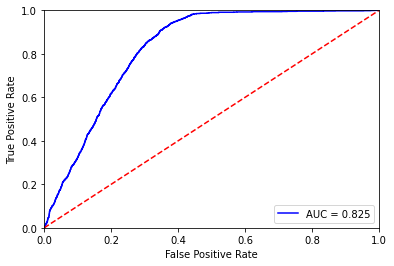

In [239]:
fpr, tpr, threshold = metrics.roc_curve(y_test_rf, y_pred_prob_rf)
roc_auc = metrics.auc(fpr, tpr)
auc_rf = metrics.roc_auc_score(y_test_rf, y_pred_prob_rf)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Benefit structure 

### Benefit stucture 1

- Promote to an interested customer + 10
- Miss an interested customer - 10
- Promote to an uninterested customer - 2
- Each promotion - 1

#### Calculate Benefit Structure score 

In [257]:
def benefit_str_1(probability_threshold_1):
    y_pred_prob_rf = RandomForestCLF.predict_proba(X_test_rf)[:, 1]
    probability_threshold_rf = probability_threshold_1
    y_pred_threshold_rf = (y_pred_prob_rf >= probability_threshold_rf).astype(int)
    confusion_matrix_rf = pd.crosstab(y_test_rf, y_pred_threshold_rf, rownames=['Actual'], colnames=['Predicted'])
    if sum(confusion_matrix_rf.loc[:,0]) != 10000: 
        points = (sum(confusion_matrix_rf.loc[:,1])*-1) + (confusion_matrix_rf.loc[0,1]*-2) + (confusion_matrix_rf.loc[1,0]* -10) + (confusion_matrix_rf.loc[1,1]*10)
    else:
        points = confusion_matrix_rf.loc[1,0]*-10
    print( 'Threshold =', probability_threshold_1,': Total Benefit Structure Score is', points)

In [258]:
benefit_str_1(0.01)
benefit_str_1(0.1)
benefit_str_1(0.2)
benefit_str_1(0.5)

Threshold = 0.01 : Total Benefit Structure Score is -12291
Threshold = 0.1 : Total Benefit Structure Score is 508
Threshold = 0.2 : Total Benefit Structure Score is 37
Threshold = 0.5 : Total Benefit Structure Score is -13640


###  Benefit structure 2
- Promote to an interested customer + 100
- Miss an interested customer - 100
- Promote to an uninterested customer - 2
- Each promotion - 1

#### Calculate benefit structure score

In [255]:
def benefit_str_2(probability_threshold_2):
    y_pred_prob_rf = RandomForestCLF.predict_proba(X_test_rf)[:, 1]
    probability_threshold_rf = probability_threshold_2
    y_pred_threshold_rf = (y_pred_prob_rf >= probability_threshold_rf).astype(int)
    confusion_matrix_rf = pd.crosstab(y_test_rf, y_pred_threshold_rf, rownames=['Actual'], colnames=['Predicted'])
    if sum(confusion_matrix_rf.loc[:,0]) != 10000: 
        points = (sum(confusion_matrix_rf.loc[:,1])*-1) + (confusion_matrix_rf.loc[0,1]*-2) + (confusion_matrix_rf.loc[1,0]* -100) + (confusion_matrix_rf.loc[1,1]*100)
    else:
        points = confusion_matrix_rf.loc[1,0]*-100
    
    print( 'Threshold =', probability_threshold_2,': Total Benefit Structure Score is', points)

In [256]:
benefit_str_2(0.01)
benefit_str_2(0.1)
benefit_str_2(0.2)
benefit_str_2(0.5)

Threshold = 0.01 : Total Benefit Structure Score is 110469
Threshold = 0.1 : Total Benefit Structure Score is 114268
Threshold = 0.2 : Total Benefit Structure Score is 85177
Threshold = 0.5 : Total Benefit Structure Score is -136400
